In [2]:
import pm4py
import csv
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
import os
import pickle

# Plotting address balance by registration date

In [3]:
# load balance sheet (see 1_Forsage_Ether_analysis.ipynb)

curr_dir = os.getcwd()
dir_path = os.path.dirname(curr_dir)

file = "balance"
path = os.path.join(dir_path, "resources", file + ".pkl")
balance = pickle.load(open(path, 'rb'))

In [5]:
# load log as dataframe (see 2_Forsage_log_sampling.ipynb)

curr_dir = os.getcwd()
dir_path = os.path.dirname(curr_dir)

file = "df_log"
path = os.path.join(dir_path, "resources", file + ".pkl")
df_log = pickle.load(open(path, 'rb'))

In [6]:
# y-axis: start date
# x-axis: ETH earned

pyramide_slice = balance.address.tolist()

mask = df_log["case:concept:name"].isin(pyramide_slice)
df_sublog = df_log[mask]
df_sublog.drop(columns=["transactionIndex", "referrer", "level", "ident:eid", "case:ident:piid", "referred", "place", "userId", "user", "caller", "currentReferrer", "from"], inplace=True)
# set and convert timestamp as such
df_sublog = df_sublog.fillna('')
df_sublog['time:timestamp'] = pd.to_datetime(df_sublog['time:timestamp'])
# sort
df_sublog = df_sublog.sort_values(by=['time:timestamp', 'logIndex'])
#mask for registration
mask_register = df_sublog['concept:name'].str.contains("Register")
df_sublog = df_sublog[mask_register]
df_sublog = df_sublog.fillna('')
    
df_sublog.reset_index(inplace=True)

df_sublog.rename(columns={"case:concept:name": "address"}, inplace=True)
df_sublog = pd.DataFrame.merge(df_sublog,balance,on='address')

df_sublog.drop(columns=["index", "logIndex", "concept:name"], inplace=True)

C:\Users\richa\AppData\Local\Temp\ipykernel_16140\4078849566.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sublog.drop(columns=["transactionIndex", "referrer", "level", "ident:eid", "case:ident:piid", "referred", "place", "userId", "user", "caller", "currentReferrer", "from"], inplace=True)


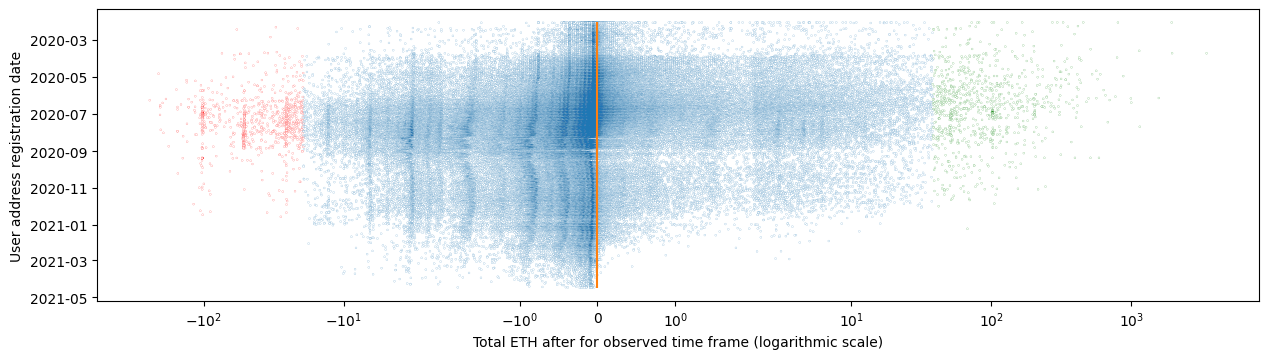

In [7]:
df_plot = df_sublog.copy()

max_smallest = max(df_plot.nsmallest(1000, "total_ETH").total_ETH)
min_largest = min(df_plot.nlargest(1001, "total_ETH").total_ETH)


df_plot["color"] = "C0"
df_plot.loc[(df_plot["total_ETH"]<=max_smallest), "color"] = "red"
df_plot.loc[(df_plot["total_ETH"]>=min_largest), "color"] = "green"

import datetime
df_plot.reset_index(inplace=True)
df_plot["time:timestamp"] = df_plot["time:timestamp"] + df_plot["index"].apply(lambda x: datetime.timedelta(milliseconds=x))
#type(df_plot["fulldate"][1])

#df_sublog.sort_values("time:timestamp", ascending=True).plot(x="total_ETH", y="time:timestamp", kind="scatter", s=1, facecolors="white", edgecolors='C0')#, c=df_plot["color"])
#df_sublog.sort_values("time:timestamp", ascending=True, inplace=True)
#df_sublog['time:timestamp'] = pd.to_datetime(df_sublog['time:timestamp'])
plt.figure(figsize=(15, 4))
plt.scatter(x=df_plot["total_ETH"], y=df_plot["time:timestamp"].tolist(), marker="o", facecolors='white', edgecolors=df_plot["color"], linewidth=.1, s=2)#, c=df_plot["color"])
plt.gca().invert_yaxis()
plt.xscale('symlog')
#plt.yticks(range(0,len(df_sublog.index)), df_sublog["time:timestamp"])
plt.xlabel("Total ETH after for observed time frame (logarithmic scale)")
plt.ylabel("User address registration date")
plt.vlines(0, ymin=min(df_plot["time:timestamp"]), ymax=max(df_plot["time:timestamp"]), colors='C1', linestyles='solid')
plt.subplots_adjust(bottom=0.15)
#path = "<path-to-image-destination.png>"
#plt.savefig(path,dpi=600)
plt.show()